In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

os.chdir('/home/mattho/git/ltu-cmass/notebooks')

0.6056622 23765.723
0.009763996 317.983
5.2189426 264.03848
8.20555 nan


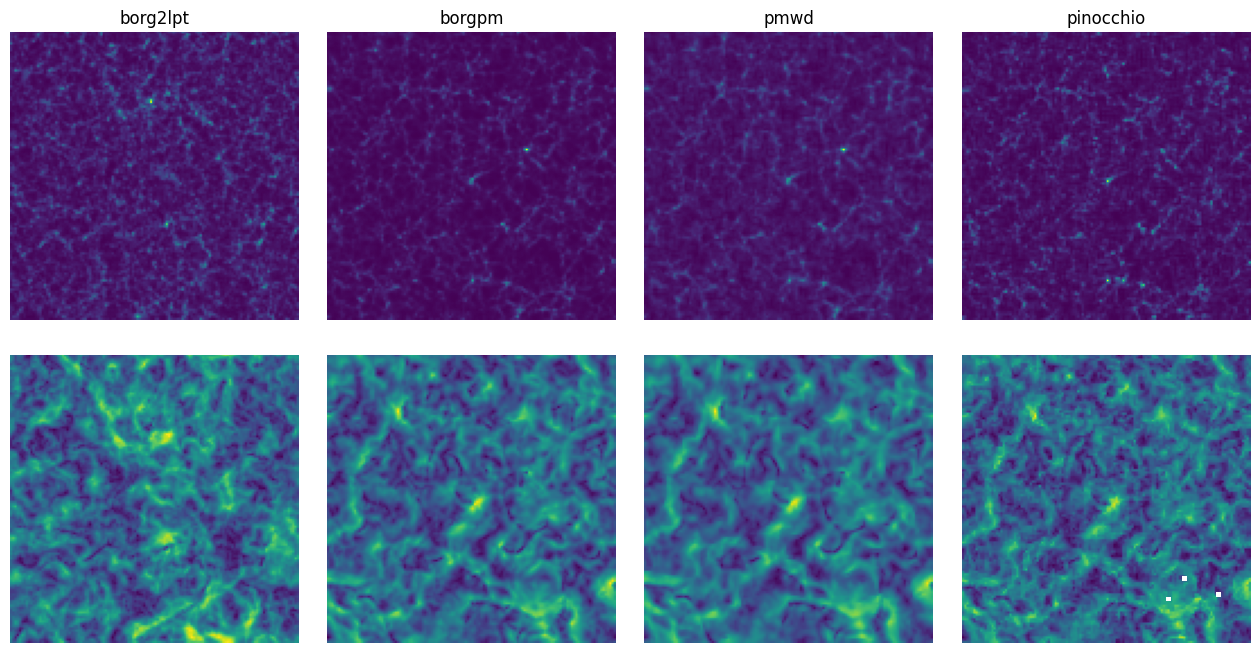

In [2]:
# temp
mlist = ['borg2lpt', 'borgpm', 'pmwd', 'pinocchio']

f, axs = plt.subplots(
    2,len(mlist), figsize=(4*len(mlist),8), 
    gridspec_kw=dict(hspace=0.1, wspace=0.1)
)

for i, m in enumerate(mlist):
    path = f"/home/mattho/git/ltu-cmass/data/test/{m}/L1000-N128/100"

    rho = np.load(join(path, 'rho.npy'))
    fvel = np.load(join(path, 'fvel.npy'))
    print(rho.std(), fvel.std())

    ax = axs[0,i]
    ax.imshow(rho[0])
    ax.axis('off')
    ax.set_title(m)

    ax = axs[1,i]
    ax.imshow(np.linalg.norm(fvel[0], axis=-1))
    ax.axis('off')


## Suite

In [3]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/charm_1gpch_z0.5/borgpm/L1000-N128/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1
c

  4%|▍         | 84/2000 [00:00<00:02, 783.87it/s]

 64%|██████▎   | 1270/2000 [00:01<00:00, 885.07it/s]


KeyboardInterrupt: 

In [ ]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values
cosmos

array([[0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ],
       [0.2139 , 0.05557, 0.8599 , 0.9785 , 0.8619 ],
       [0.1867 , 0.04503, 0.6189 , 0.8307 , 0.7187 ],
       ...,
       [0.4017 , 0.04425, 0.8509 , 0.8251 , 0.7833 ],
       [0.2953 , 0.04701, 0.8017 , 0.8193 , 0.6627 ],
       [0.3175 , 0.049  , 0.6711 , 0.9624 , 0.834  ]])

In [ ]:
# Load Pks
pks = np.zeros((len(cosmos), 399))
for r in tqdm(os.listdir(suitepath)):
    try:
        pk = np.load(join(suitepath, r, 'Pk', 'Pk0.npz'))
    except FileNotFoundError:
        continue
    k_gal = pk['k_gal']
    p0 = pk['p0k_gal']
    pks[int(r)] = p0

100%|██████████| 2000/2000 [00:01<00:00, 1731.36it/s]


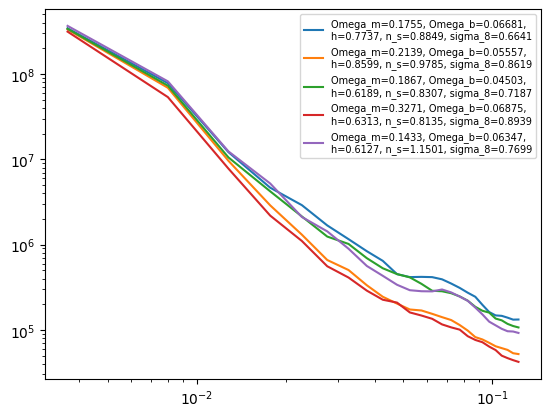

In [ ]:
plt.loglog()

for i in range(5):
    lstr = f"Omega_m={cosmos[i,0]}, Omega_b={cosmos[i,1]}, \n"
    lstr += f"h={cosmos[i,2]}, n_s={cosmos[i,3]}, sigma_8={cosmos[i,4]}"
    plt.plot(k_gal, pks[i], label=lstr)
plt.legend(fontsize=7)

## Inference

In [2]:
mask = np.all(pks==0, axis=1)
pks = pks[~mask]
cosmos = cosmos[~mask]

x = np.log10(pks[:2000,:25])
theta = cosmos[:2000]

NameError: name 'pks' is not defined

In [ ]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cpu'

In [ ]:
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=theta.min(axis=0),
    high=theta.max(axis=0),
    device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args
)

In [ ]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
244 epochs [02:47,  1.46 epochs/s, loss=-13.1, loss_val=-12]  
INFO:root:Training model 2 / 2.
271 epochs [02:30,  1.81 epochs/s, loss=-12.4, loss_val=-11.6]
INFO:root:It took 317.7501962184906 seconds to train models.


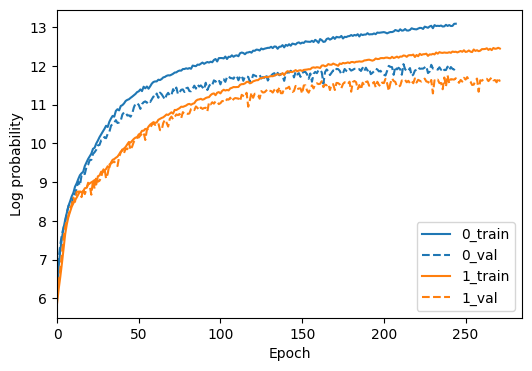

In [15]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

INFO:root:Sampling models with tensor([572., 428.]) samples each.
Drawing 572 posterior samples: 1109it [00:00, 6174.46it/s]                        
Drawing 428 posterior samples: 778it [00:00, 14247.72it/s]            


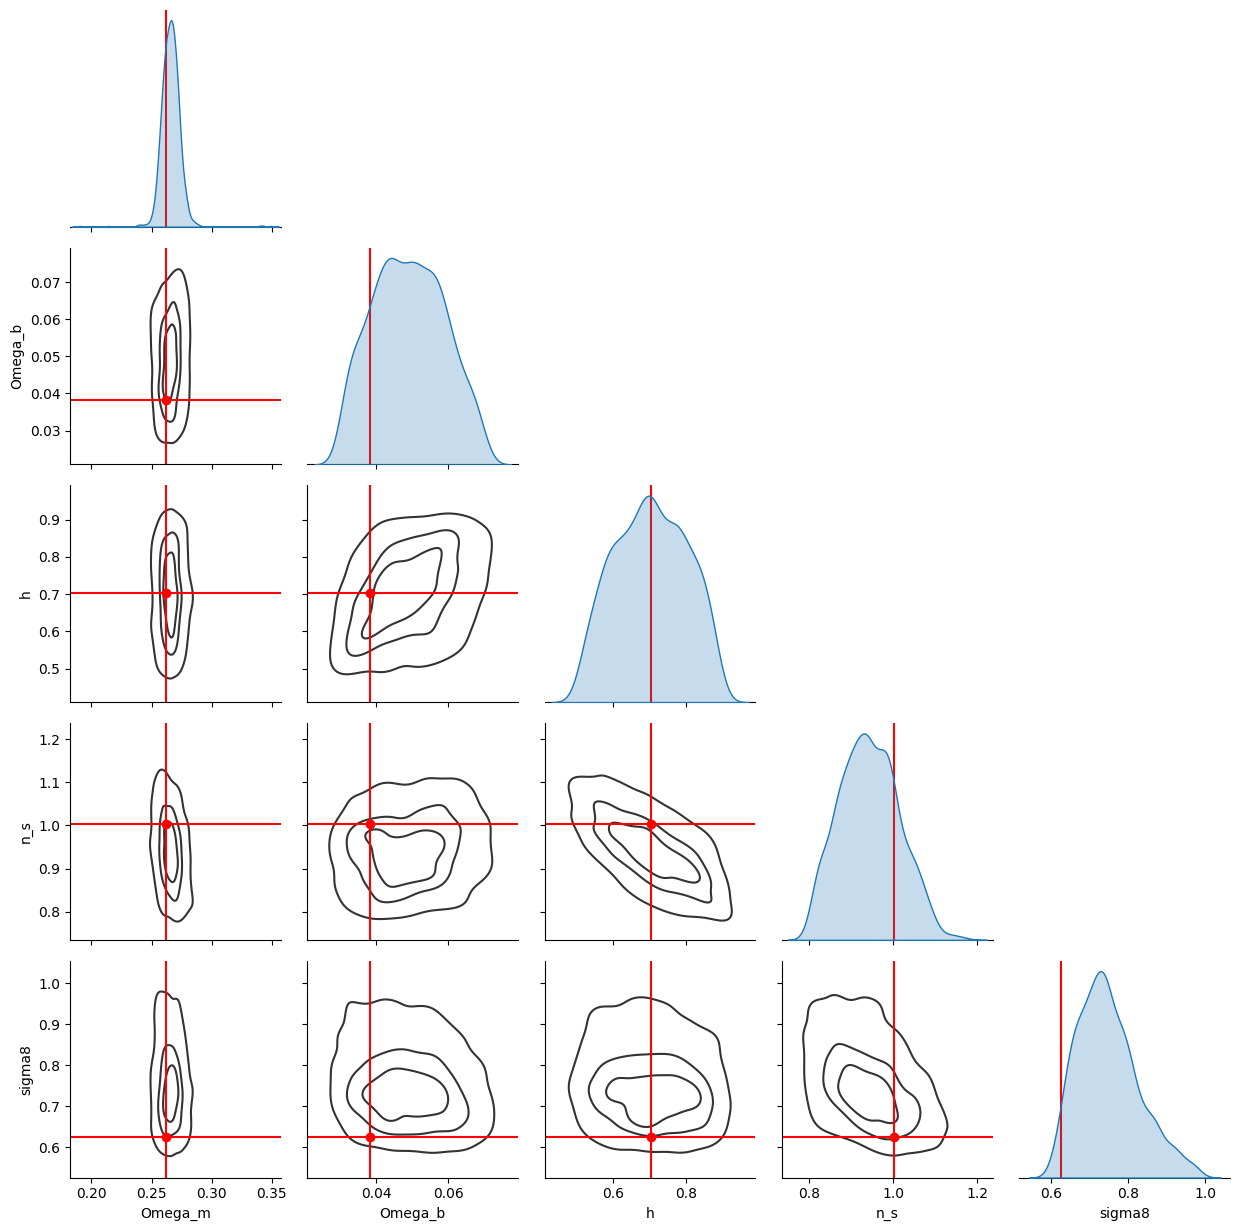

In [16]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
    # labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind]
)

100%|██████████| 1999/1999 [06:07<00:00,  5.44it/s] 
INFO:root:Mean logprob: 1.2509e+01Median logprob: 1.2591e+01
100%|██████████| 100/100 [00:13<00:00,  7.24it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


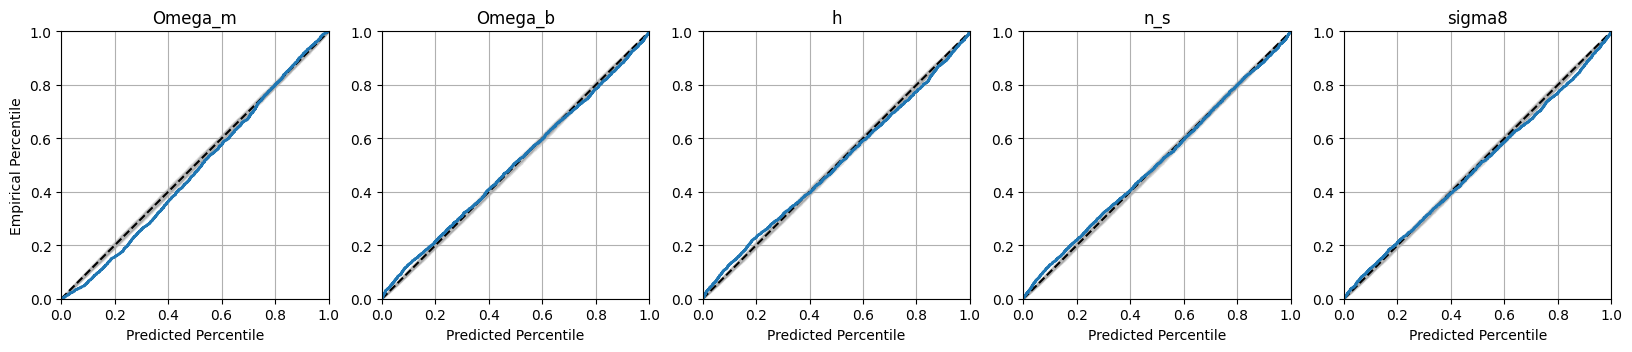

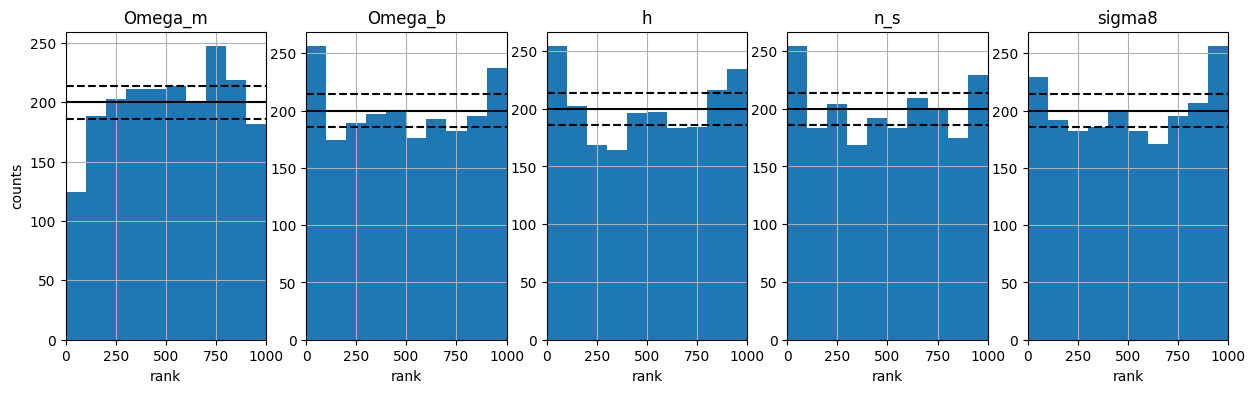

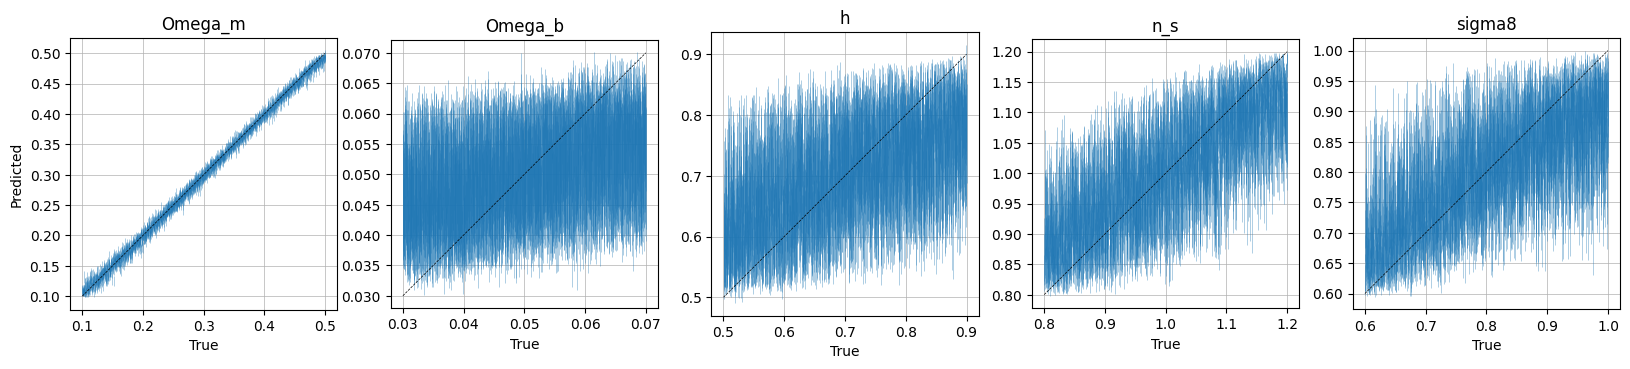

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


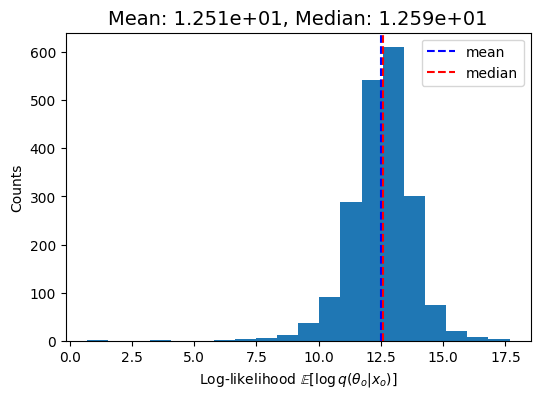

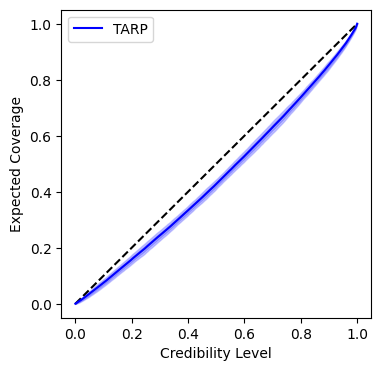

In [17]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

## Compare suite on every level

In [3]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def Pk3D(x, L=1000, MAS='None', axis=0, threads=16):
    # handle multiple x's
    if len(x.shape) == 4:
        results = [Pk3D(xi, L, MAS, axis, threads) for xi in x]
        k, Pk = list(zip(*results))
        return np.array(k), np.array(Pk)

    Pk = PKL.Pk(x.astype(np.float32),
                L, axis, MAS, threads, verbose=0)
    return Pk.k1D, Pk.Pk1D

In [5]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/inf_3gpch/borgpm/L3000-N384/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1
c

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:25<00:00, 78.82it/s] 


Counter({'config.yaml': 2000,
         'nbody.h5': 2000,
         'transfer.h5': 2000,
         'galaxies': 1988,
         'lightcone': 1988,
         'summary': 1987,
         'halos.h5': 1966,
         'diag': 356})

In [8]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values
# cosmos = cosmos[:1000]  # only 1000 sims run

Nsims = len(cosmos)
mask = np.ones(Nsims, dtype=bool)
mask[-1] = False

In [7]:
# Measure rho power spectra
rho_pk = []
# for p in tqdm(range(Nsims)):
#     try:
#         rho = np.load(join(suitepath, str(p), 'rho.npy'))
#         cfg = OmegaConf.load(join(suitepath, str(p), 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         rho_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L
    
#     k, _Pk = Pk3D(rho, L=L, MAS='CIC', threads=20)
#     rho_pk.append(_Pk)
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'rho.h5')
        with h5py.File(filename, 'r') as f:
            a = list(f.keys())[0]
            k = f[a]['k'][:]
            _Pk = f[a]['Pk'][:,0]
        rho_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        rho_pk.append(_Pk)
        continue
        

  5%|▌         | 102/2001 [00:03<00:12, 157.31it/s]

Skipping 38.
Skipping 39.
Skipping 40.
Skipping 41.
Skipping 42.
Skipping 43.
Skipping 44.
Skipping 45.
Skipping 46.
Skipping 47.
Skipping 48.
Skipping 49.
Skipping 50.
Skipping 51.
Skipping 52.
Skipping 53.
Skipping 54.
Skipping 55.
Skipping 56.
Skipping 57.
Skipping 58.
Skipping 59.
Skipping 60.
Skipping 61.
Skipping 62.
Skipping 63.
Skipping 64.
Skipping 65.
Skipping 66.
Skipping 67.
Skipping 68.
Skipping 69.
Skipping 70.
Skipping 71.
Skipping 72.
Skipping 73.
Skipping 74.
Skipping 75.
Skipping 76.
Skipping 77.
Skipping 78.
Skipping 79.
Skipping 80.
Skipping 81.
Skipping 82.
Skipping 83.
Skipping 84.
Skipping 85.
Skipping 86.
Skipping 87.
Skipping 88.
Skipping 89.
Skipping 90.
Skipping 91.
Skipping 92.
Skipping 93.
Skipping 94.
Skipping 95.
Skipping 96.
Skipping 97.
Skipping 98.
Skipping 99.


 10%|█         | 202/2001 [00:05<00:22, 78.79it/s] 

Skipping 138.
Skipping 139.
Skipping 140.
Skipping 141.
Skipping 142.
Skipping 143.
Skipping 144.
Skipping 145.
Skipping 146.
Skipping 147.
Skipping 148.
Skipping 149.
Skipping 150.
Skipping 151.
Skipping 152.
Skipping 153.
Skipping 154.
Skipping 155.
Skipping 156.
Skipping 157.
Skipping 158.
Skipping 159.
Skipping 160.
Skipping 161.
Skipping 162.
Skipping 163.
Skipping 164.
Skipping 165.
Skipping 166.
Skipping 167.
Skipping 168.
Skipping 169.
Skipping 170.
Skipping 171.
Skipping 172.
Skipping 173.
Skipping 174.
Skipping 175.
Skipping 176.
Skipping 177.
Skipping 178.
Skipping 179.
Skipping 180.
Skipping 181.
Skipping 182.
Skipping 183.
Skipping 184.
Skipping 185.
Skipping 186.
Skipping 187.
Skipping 188.
Skipping 189.
Skipping 190.
Skipping 191.
Skipping 192.
Skipping 193.
Skipping 194.
Skipping 195.
Skipping 196.
Skipping 197.
Skipping 198.
Skipping 199.


 15%|█▌        | 302/2001 [00:07<00:22, 76.47it/s]

Skipping 238.
Skipping 239.
Skipping 240.
Skipping 241.
Skipping 242.
Skipping 243.
Skipping 244.
Skipping 245.
Skipping 246.
Skipping 247.
Skipping 248.
Skipping 249.
Skipping 250.
Skipping 251.
Skipping 252.
Skipping 253.
Skipping 254.
Skipping 255.
Skipping 256.
Skipping 257.
Skipping 258.
Skipping 259.
Skipping 260.
Skipping 261.
Skipping 262.
Skipping 263.
Skipping 264.
Skipping 265.
Skipping 266.
Skipping 267.
Skipping 268.
Skipping 269.
Skipping 270.
Skipping 271.
Skipping 272.
Skipping 273.
Skipping 274.
Skipping 275.
Skipping 276.
Skipping 277.
Skipping 278.
Skipping 279.
Skipping 280.
Skipping 281.
Skipping 282.
Skipping 283.
Skipping 284.
Skipping 285.
Skipping 286.
Skipping 287.
Skipping 288.
Skipping 289.
Skipping 290.
Skipping 291.
Skipping 292.
Skipping 293.
Skipping 294.
Skipping 295.
Skipping 296.
Skipping 297.
Skipping 298.
Skipping 299.


 20%|██        | 404/2001 [00:09<00:15, 101.97it/s]

Skipping 338.
Skipping 339.
Skipping 340.
Skipping 341.
Skipping 342.
Skipping 343.
Skipping 344.
Skipping 345.
Skipping 346.
Skipping 347.
Skipping 348.
Skipping 349.
Skipping 350.
Skipping 351.
Skipping 352.
Skipping 353.
Skipping 354.
Skipping 355.
Skipping 356.
Skipping 357.
Skipping 358.
Skipping 359.
Skipping 360.
Skipping 361.
Skipping 362.
Skipping 363.
Skipping 364.
Skipping 365.
Skipping 366.
Skipping 367.
Skipping 368.
Skipping 369.
Skipping 370.
Skipping 371.
Skipping 372.
Skipping 373.
Skipping 374.
Skipping 375.
Skipping 376.
Skipping 377.
Skipping 378.
Skipping 379.
Skipping 380.
Skipping 381.
Skipping 382.
Skipping 383.
Skipping 384.
Skipping 385.
Skipping 386.
Skipping 387.
Skipping 388.
Skipping 389.
Skipping 390.
Skipping 391.
Skipping 392.
Skipping 393.
Skipping 394.
Skipping 395.
Skipping 396.
Skipping 397.
Skipping 398.
Skipping 399.


 25%|██▌       | 502/2001 [00:10<00:16, 89.92it/s] 

Skipping 438.
Skipping 439.
Skipping 440.
Skipping 441.
Skipping 442.
Skipping 443.
Skipping 444.
Skipping 445.
Skipping 446.
Skipping 447.
Skipping 448.
Skipping 449.
Skipping 450.
Skipping 451.
Skipping 452.
Skipping 453.
Skipping 454.
Skipping 455.
Skipping 456.
Skipping 457.
Skipping 458.
Skipping 459.
Skipping 460.
Skipping 461.
Skipping 462.
Skipping 463.
Skipping 464.
Skipping 465.
Skipping 466.
Skipping 467.
Skipping 468.
Skipping 469.
Skipping 470.
Skipping 471.
Skipping 472.
Skipping 473.
Skipping 474.
Skipping 475.
Skipping 476.
Skipping 477.
Skipping 478.
Skipping 479.
Skipping 480.
Skipping 481.
Skipping 482.
Skipping 483.
Skipping 484.
Skipping 485.
Skipping 486.
Skipping 487.
Skipping 488.
Skipping 489.
Skipping 490.
Skipping 491.
Skipping 492.
Skipping 493.
Skipping 494.
Skipping 495.
Skipping 496.
Skipping 497.
Skipping 498.
Skipping 499.


 27%|██▋       | 540/2001 [00:15<01:07, 21.73it/s]

Skipping 538.
Skipping 539.
Skipping 540.
Skipping 541.
Skipping 542.
Skipping 543.
Skipping 544.
Skipping 545.
Skipping 546.
Skipping 547.
Skipping 548.
Skipping 549.
Skipping 550.
Skipping 551.
Skipping 552.
Skipping 553.
Skipping 554.
Skipping 555.
Skipping 556.
Skipping 557.
Skipping 558.
Skipping 559.
Skipping 560.
Skipping 561.
Skipping 562.
Skipping 563.
Skipping 564.
Skipping 565.
Skipping 566.
Skipping 567.
Skipping 568.
Skipping 569.
Skipping 570.
Skipping 571.
Skipping 572.
Skipping 573.
Skipping 574.
Skipping 575.
Skipping 576.
Skipping 577.
Skipping 578.
Skipping 579.
Skipping 580.
Skipping 581.
Skipping 582.
Skipping 583.
Skipping 584.
Skipping 585.
Skipping 586.
Skipping 587.
Skipping 588.
Skipping 589.
Skipping 590.
Skipping 591.
Skipping 592.
Skipping 593.
Skipping 594.
Skipping 595.
Skipping 596.
Skipping 597.
Skipping 598.
Skipping 599.


 31%|███       | 617/2001 [00:16<00:41, 33.10it/s]

Skipping 615.
Skipping 616.


 35%|███▌      | 703/2001 [00:17<00:22, 57.48it/s]

Skipping 638.
Skipping 639.
Skipping 640.
Skipping 641.
Skipping 642.
Skipping 643.
Skipping 644.
Skipping 645.
Skipping 646.
Skipping 647.
Skipping 648.
Skipping 649.
Skipping 650.
Skipping 651.
Skipping 652.
Skipping 653.
Skipping 654.
Skipping 655.
Skipping 656.
Skipping 657.
Skipping 658.
Skipping 659.
Skipping 660.
Skipping 661.
Skipping 662.
Skipping 663.
Skipping 664.
Skipping 665.
Skipping 666.
Skipping 667.
Skipping 668.
Skipping 669.
Skipping 670.
Skipping 671.
Skipping 672.
Skipping 673.
Skipping 674.
Skipping 675.
Skipping 676.
Skipping 677.
Skipping 678.
Skipping 679.
Skipping 680.
Skipping 681.
Skipping 682.
Skipping 683.
Skipping 684.
Skipping 685.
Skipping 686.
Skipping 687.
Skipping 688.
Skipping 689.
Skipping 690.
Skipping 691.
Skipping 692.
Skipping 693.
Skipping 694.
Skipping 695.
Skipping 696.
Skipping 697.
Skipping 698.
Skipping 699.
Skipping 704.


 36%|███▌      | 720/2001 [00:18<00:25, 50.39it/s]

Skipping 715.
Skipping 716.
Skipping 717.
Skipping 719.
Skipping 721.
Skipping 722.


 37%|███▋      | 743/2001 [00:18<00:23, 52.55it/s]

Skipping 728.
Skipping 729.
Skipping 738.
Skipping 739.
Skipping 740.
Skipping 741.
Skipping 742.
Skipping 743.
Skipping 744.
Skipping 745.
Skipping 746.
Skipping 747.
Skipping 748.
Skipping 749.
Skipping 750.
Skipping 751.
Skipping 752.
Skipping 753.
Skipping 754.
Skipping 755.
Skipping 756.
Skipping 757.
Skipping 758.
Skipping 759.
Skipping 760.


 40%|████      | 804/2001 [00:18<00:11, 108.52it/s]

Skipping 761.
Skipping 762.
Skipping 763.
Skipping 764.
Skipping 765.
Skipping 766.
Skipping 767.
Skipping 768.
Skipping 769.
Skipping 770.
Skipping 771.
Skipping 772.
Skipping 773.
Skipping 774.
Skipping 775.
Skipping 776.
Skipping 777.
Skipping 778.
Skipping 779.
Skipping 780.
Skipping 781.
Skipping 782.
Skipping 783.
Skipping 784.
Skipping 785.
Skipping 786.
Skipping 787.
Skipping 788.
Skipping 789.
Skipping 790.
Skipping 791.
Skipping 792.
Skipping 793.
Skipping 794.
Skipping 795.
Skipping 796.
Skipping 797.
Skipping 798.
Skipping 799.
Skipping 800.
Skipping 804.


 41%|████▏     | 828/2001 [00:18<00:11, 101.43it/s]

Skipping 810.
Skipping 815.
Skipping 816.
Skipping 817.
Skipping 818.
Skipping 819.
Skipping 821.
Skipping 822.
Skipping 825.
Skipping 826.
Skipping 827.
Skipping 828.
Skipping 829.
Skipping 831.


 45%|████▌     | 903/2001 [00:19<00:07, 154.64it/s]

Skipping 838.
Skipping 839.
Skipping 840.
Skipping 841.
Skipping 842.
Skipping 843.
Skipping 844.
Skipping 845.
Skipping 846.
Skipping 847.
Skipping 848.
Skipping 849.
Skipping 850.
Skipping 851.
Skipping 852.
Skipping 853.
Skipping 854.
Skipping 855.
Skipping 856.
Skipping 857.
Skipping 858.
Skipping 859.
Skipping 860.
Skipping 861.
Skipping 862.
Skipping 863.
Skipping 864.
Skipping 865.
Skipping 866.
Skipping 867.
Skipping 868.
Skipping 869.
Skipping 870.
Skipping 871.
Skipping 872.
Skipping 873.
Skipping 874.
Skipping 875.
Skipping 876.
Skipping 877.
Skipping 878.
Skipping 879.
Skipping 880.
Skipping 881.
Skipping 882.
Skipping 883.
Skipping 884.
Skipping 885.
Skipping 886.
Skipping 887.
Skipping 888.
Skipping 889.
Skipping 890.
Skipping 891.
Skipping 892.
Skipping 893.
Skipping 894.
Skipping 895.
Skipping 896.
Skipping 897.
Skipping 898.
Skipping 899.
Skipping 900.
Skipping 904.


 46%|████▌     | 923/2001 [00:19<00:22, 47.09it/s] 

Skipping 910.
Skipping 914.
Skipping 915.
Skipping 916.
Skipping 917.
Skipping 918.
Skipping 919.
Skipping 921.
Skipping 922.


BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [36]:
# Measure halo power spectra

halo_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'halos.h5')
        with h5py.File(filename, 'r') as f:
            a = list(f.keys())[0]
            k = f[a]['Pk_k'][:]
            _Pk = f[a]['Pk'][:,0]
        halo_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        halo_pk.append(_Pk)
        continue
    

# MAS = 'NGP'
# halo_pk = []
# for p in tqdm(range(Nsims)):
#     try:
#         hpos = np.load(join(suitepath, str(p), 'halo_pos.npy'))
#         cfg = OmegaConf.load(join(suitepath, str(p), 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         halo_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=32)
#     halo_pk.append(_Pk)

  1%|▏         | 27/2001 [00:00<00:07, 266.30it/s]

 79%|███████▉  | 1576/2001 [00:03<00:01, 382.32it/s]

Skipping 1500.


 94%|█████████▍| 1880/2001 [00:04<00:00, 437.36it/s]

Skipping 1800.


100%|██████████| 2001/2001 [00:06<00:00, 321.96it/s]

Skipping 2000.


In [37]:
# Measure halo power spectra in redshift space

haloz_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'halos.h5')
        with h5py.File(filename, 'r') as f:
            a = list(f.keys())[0]
            k = f[a]['zPk_k'][:]
            _Pk = f[a]['zPk'][:,0]
        haloz_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        haloz_pk.append(_Pk)
        continue

# MAS = 'NGP'
# haloz_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         hpos = np.load(join(suitepath, p, 'halo_pos.npy'))
#         hvel = np.load(join(suitepath, p, 'halo_vel.npy'))
#         cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         haloz_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L
#     h = cfg.nbody.cosmo[2]

#     RSL.pos_redshift_space(hpos, hvel, L, Hubble=h*100, redshift=0.5, axis=0)

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=32)
#     haloz_pk.append(_Pk)

  4%|▎         | 74/2001 [00:00<00:02, 734.95it/s]

 81%|████████  | 1612/2001 [00:02<00:00, 792.62it/s]

Skipping 1500.


 96%|█████████▌| 1919/2001 [00:02<00:00, 740.36it/s]

Skipping 1800.


100%|██████████| 2001/2001 [00:02<00:00, 772.75it/s]

Skipping 2000.


In [38]:
# Measure galaxy power spectra
hod = 0

gal_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'galaxies', 'hod000.h5')
        with h5py.File(filename, 'r') as f:
            a = list(f.keys())[0]
            k = f[a]['Pk_k'][:]
            _Pk = f[a]['Pk'][:,0]
        gal_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        gal_pk.append(_Pk)
        continue


# MAS = 'NGP'
# gal_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         gpos = np.load(join(suitepath, p, 'hod', f'hod{hod}_pos.npy'))
#         cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         gal_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=16)
#     gal_pk.append(_Pk)

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 5/2001 [00:00<00:48, 41.17it/s]

Skipping 0.
Skipping 1.
Skipping 2.
Skipping 3.
Skipping 4.
Skipping 5.
Skipping 6.


  0%|          | 10/2001 [00:00<01:02, 32.02it/s]

Skipping 7.
Skipping 8.
Skipping 9.
Skipping 10.
Skipping 11.
Skipping 12.


  1%|          | 14/2001 [00:00<01:16, 26.08it/s]

Skipping 13.
Skipping 14.


  1%|          | 19/2001 [00:00<01:16, 25.97it/s]

Skipping 15.
Skipping 16.
Skipping 17.
Skipping 18.
Skipping 19.


  2%|▏         | 46/2001 [00:01<00:32, 60.46it/s]

Skipping 20.
Skipping 21.
Skipping 22.
Skipping 23.
Skipping 24.
Skipping 25.
Skipping 26.
Skipping 27.
Skipping 28.
Skipping 29.
Skipping 30.
Skipping 31.
Skipping 32.
Skipping 33.
Skipping 34.
Skipping 35.
Skipping 36.
Skipping 37.
Skipping 38.
Skipping 39.
Skipping 40.
Skipping 41.
Skipping 42.
Skipping 43.
Skipping 44.
Skipping 45.
Skipping 46.


  3%|▎         | 60/2001 [00:01<00:39, 48.67it/s]

Skipping 47.
Skipping 48.
Skipping 49.
Skipping 50.
Skipping 51.
Skipping 52.
Skipping 53.
Skipping 54.
Skipping 55.
Skipping 56.
Skipping 57.
Skipping 58.
Skipping 59.
Skipping 60.
Skipping 61.


  4%|▎         | 71/2001 [00:01<00:42, 44.98it/s]

Skipping 62.
Skipping 63.
Skipping 64.
Skipping 65.
Skipping 66.
Skipping 67.
Skipping 68.
Skipping 69.
Skipping 70.
Skipping 71.
Skipping 72.
Skipping 73.
Skipping 74.
Skipping 75.
Skipping 76.
Skipping 77.
Skipping 78.
Skipping 79.
Skipping 80.
Skipping 81.
Skipping 82.
Skipping 83.
Skipping 84.
Skipping 85.
Skipping 86.
Skipping 87.
Skipping 88.
Skipping 89.
Skipping 90.
Skipping 91.
Skipping 92.
Skipping 93.
Skipping 94.
Skipping 95.
Skipping 96.
Skipping 97.
Skipping 98.
Skipping 99.
Skipping 100.
Skipping 101.
Skipping 102.
Skipping 103.
Skipping 104.
Skipping 105.
Skipping 106.
Skipping 107.
Skipping 108.
Skipping 109.
Skipping 110.
Skipping 111.
Skipping 112.
Skipping 113.
Skipping 114.
Skipping 115.
Skipping 116.
Skipping 117.
Skipping 118.
Skipping 119.
Skipping 120.
Skipping 121.
Skipping 122.
Skipping 123.
Skipping 124.
Skipping 125.
Skipping 126.
Skipping 127.
Skipping 128.
Skipping 129.
Skipping 130.
Skipping 131.
Skipping 132.
Skipping 133.
Skipping 134.
Skipping 135.
Sk

 42%|████▏     | 834/2001 [00:01<00:00, 1558.67it/s]


Skipping 307.
Skipping 308.
Skipping 309.
Skipping 310.
Skipping 311.
Skipping 312.
Skipping 313.
Skipping 314.
Skipping 315.
Skipping 316.
Skipping 317.
Skipping 318.
Skipping 319.
Skipping 320.
Skipping 321.
Skipping 322.
Skipping 323.
Skipping 324.
Skipping 325.
Skipping 326.
Skipping 327.
Skipping 328.
Skipping 329.
Skipping 330.
Skipping 331.
Skipping 332.
Skipping 333.
Skipping 334.
Skipping 335.
Skipping 336.
Skipping 337.
Skipping 338.
Skipping 339.
Skipping 340.
Skipping 341.
Skipping 342.
Skipping 343.
Skipping 344.
Skipping 345.
Skipping 346.
Skipping 347.
Skipping 348.
Skipping 349.
Skipping 350.
Skipping 351.
Skipping 352.
Skipping 353.
Skipping 354.
Skipping 355.
Skipping 356.
Skipping 357.
Skipping 358.
Skipping 359.
Skipping 360.
Skipping 361.
Skipping 362.
Skipping 363.
Skipping 364.
Skipping 365.
Skipping 366.
Skipping 367.
Skipping 368.
Skipping 369.
Skipping 370.
Skipping 371.
Skipping 372.
Skipping 373.
Skipping 374.
Skipping 375.
Skipping 376.
Skipping 377.
Skipp

 74%|███████▍  | 1483/2001 [00:02<00:00, 2329.09it/s]

Skipping 1008.
Skipping 1009.
Skipping 1010.
Skipping 1011.
Skipping 1012.
Skipping 1013.
Skipping 1014.
Skipping 1015.
Skipping 1016.
Skipping 1017.
Skipping 1018.
Skipping 1019.
Skipping 1020.
Skipping 1021.
Skipping 1022.
Skipping 1023.
Skipping 1024.
Skipping 1025.
Skipping 1026.
Skipping 1027.
Skipping 1028.
Skipping 1029.
Skipping 1030.
Skipping 1031.
Skipping 1032.
Skipping 1033.
Skipping 1034.
Skipping 1035.
Skipping 1036.
Skipping 1037.
Skipping 1038.
Skipping 1039.
Skipping 1040.
Skipping 1041.
Skipping 1042.
Skipping 1043.
Skipping 1044.
Skipping 1045.
Skipping 1046.
Skipping 1047.
Skipping 1048.
Skipping 1049.
Skipping 1050.
Skipping 1051.
Skipping 1052.
Skipping 1053.
Skipping 1054.
Skipping 1055.
Skipping 1056.
Skipping 1057.
Skipping 1058.
Skipping 1059.
Skipping 1060.
Skipping 1061.
Skipping 1062.
Skipping 1063.
Skipping 1064.
Skipping 1065.
Skipping 1066.
Skipping 1067.
Skipping 1068.
Skipping 1069.
Skipping 1070.
Skipping 1071.
Skipping 1072.
Skipping 1073.
Skipping 1

100%|██████████| 2001/2001 [00:02<00:00, 883.11it/s] 

Skipping 1690.
Skipping 1691.
Skipping 1692.
Skipping 1693.
Skipping 1694.
Skipping 1695.
Skipping 1696.
Skipping 1697.
Skipping 1698.
Skipping 1699.
Skipping 1700.
Skipping 1701.
Skipping 1702.
Skipping 1703.
Skipping 1704.
Skipping 1705.
Skipping 1706.
Skipping 1707.
Skipping 1708.
Skipping 1709.
Skipping 1710.
Skipping 1711.
Skipping 1712.
Skipping 1713.
Skipping 1714.
Skipping 1715.
Skipping 1716.
Skipping 1717.
Skipping 1718.
Skipping 1719.
Skipping 1720.
Skipping 1721.
Skipping 1722.
Skipping 1723.
Skipping 1724.
Skipping 1725.
Skipping 1726.
Skipping 1727.
Skipping 1728.
Skipping 1729.
Skipping 1730.
Skipping 1731.
Skipping 1732.
Skipping 1733.
Skipping 1734.
Skipping 1735.
Skipping 1736.
Skipping 1737.
Skipping 1738.
Skipping 1739.
Skipping 1740.
Skipping 1741.
Skipping 1742.
Skipping 1743.
Skipping 1744.
Skipping 1745.
Skipping 1746.
Skipping 1747.
Skipping 1748.
Skipping 1749.
Skipping 1750.
Skipping 1751.
Skipping 1752.
Skipping 1753.
Skipping 1754.
Skipping 1755.
Skipping 1

In [39]:
# Measure galaxy power spectra in redshift space
hod = 0

galz_pk = []
for p in tqdm(range(Nsims)):
    try:
        filename = join(suitepath, str(p), 'diag', 'galaxies', 'hod000.h5')
        with h5py.File(filename, 'r') as f:
            a = list(f.keys())[0]
            k = f[a]['zPk_k'][:]
            _Pk = f[a]['zPk'][:,0]
        galz_pk.append(_Pk)
    except FileNotFoundError:
        print(f"Skipping {p}.")
        mask[int(p)] = False
        galz_pk.append(_Pk)
        continue

# MAS = 'NGP'
# galz_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         gpos = np.load(join(suitepath, p, 'hod', f'hod{hod}_pos.npy')).copy(order='C')
#         gvel = np.load(join(suitepath, p, 'hod', f'hod{hod}_vel.npy')).copy(order='C')
#         cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         galz_pk.append(_Pk)
#         continue
#     N = cfg.nbody.N
#     L = cfg.nbody.L
#     h = cfg.nbody.cosmo[2]

#     RSL.pos_redshift_space(gpos, gvel, L, Hubble=h*100, redshift=0.5, axis=0)

#     delta = np.empty((N,N,N), dtype=np.float32)
#     MASL.MA(gpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
#     delta /= delta.mean()
#     delta -= 1
    
#     k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=32)
#     galz_pk.append(_Pk)

  0%|          | 0/2001 [00:00<?, ?it/s]

Skipping 0.
Skipping 1.
Skipping 2.
Skipping 3.
Skipping 4.
Skipping 5.
Skipping 6.
Skipping 7.
Skipping 8.
Skipping 9.
Skipping 10.
Skipping 11.
Skipping 12.
Skipping 13.
Skipping 14.
Skipping 15.
Skipping 16.
Skipping 17.
Skipping 18.
Skipping 19.
Skipping 20.
Skipping 21.
Skipping 22.
Skipping 23.
Skipping 24.
Skipping 25.
Skipping 26.
Skipping 27.
Skipping 28.
Skipping 29.
Skipping 30.
Skipping 31.
Skipping 32.
Skipping 33.
Skipping 34.
Skipping 35.
Skipping 36.
Skipping 37.
Skipping 38.
Skipping 39.
Skipping 40.
Skipping 41.
Skipping 42.
Skipping 43.
Skipping 44.
Skipping 45.
Skipping 46.
Skipping 47.
Skipping 48.
Skipping 49.
Skipping 50.
Skipping 51.
Skipping 52.
Skipping 53.
Skipping 54.
Skipping 55.
Skipping 56.
Skipping 57.
Skipping 58.
Skipping 59.
Skipping 60.
Skipping 61.
Skipping 62.
Skipping 63.
Skipping 64.
Skipping 65.
Skipping 66.
Skipping 67.
Skipping 68.
Skipping 69.
Skipping 70.
Skipping 71.
Skipping 72.
Skipping 73.
Skipping 74.
Skipping 75.
Skipping 76.
Skipping 

100%|██████████| 2001/2001 [00:00<00:00, 19701.04it/s]

Skipping 1797.
Skipping 1798.
Skipping 1799.
Skipping 1800.
Skipping 1801.
Skipping 1802.
Skipping 1803.
Skipping 1804.
Skipping 1805.
Skipping 1806.
Skipping 1807.
Skipping 1808.
Skipping 1809.
Skipping 1810.
Skipping 1811.
Skipping 1812.
Skipping 1813.
Skipping 1814.
Skipping 1815.
Skipping 1816.
Skipping 1817.
Skipping 1818.
Skipping 1819.
Skipping 1820.
Skipping 1821.
Skipping 1822.
Skipping 1823.
Skipping 1824.
Skipping 1825.
Skipping 1826.
Skipping 1827.
Skipping 1828.
Skipping 1829.
Skipping 1830.
Skipping 1831.
Skipping 1832.
Skipping 1833.
Skipping 1834.
Skipping 1835.
Skipping 1836.
Skipping 1837.
Skipping 1838.
Skipping 1839.
Skipping 1840.
Skipping 1841.
Skipping 1842.
Skipping 1843.
Skipping 1844.
Skipping 1845.
Skipping 1846.
Skipping 1847.
Skipping 1848.
Skipping 1849.
Skipping 1850.
Skipping 1851.
Skipping 1852.
Skipping 1853.
Skipping 1854.
Skipping 1855.
Skipping 1856.
Skipping 1857.
Skipping 1858.
Skipping 1859.
Skipping 1860.
Skipping 1861.
Skipping 1862.
Skipping 1

In [40]:
# # Load galaxy survey power spectra
# survey_pk = []
# for p in tqdm(range(Nsims)):
#     p = str(p)
#     try:
#         _Pk = np.load(join(suitepath, p, 'Pk', 'Pk0.npz'))
#     except FileNotFoundError:
#         print(f"Skipping {p}.")
#         mask[int(p)] = False
#         survey_pk.append(p0)
#         continue
#     k_sur = _Pk['k_gal']
#     p0 = _Pk['p0k_gal']
#     survey_pk.append(p0)

In [41]:
rho_pk = np.stack(rho_pk, axis=0)
halo_pk = np.stack(halo_pk, axis=0)
haloz_pk = np.stack(haloz_pk, axis=0)
gal_pk = np.stack(gal_pk, axis=0)
galz_pk = np.stack(galz_pk, axis=0)
# survey_pk = np.stack(survey_pk, axis=0)
rho_pk.shape, halo_pk.shape, haloz_pk.shape, gal_pk.shape, galz_pk.shape

((2001, 110), (2001, 110), (2001, 110), (2001, 110), (2001, 110))

In [32]:
cosmos = cosmos[mask]
rho_pk = rho_pk[mask]
halo_pk = halo_pk[mask]
haloz_pk = haloz_pk[mask]
gal_pk = gal_pk[mask]
galz_pk = galz_pk[mask]
# survey_pk = survey_pk[mask]

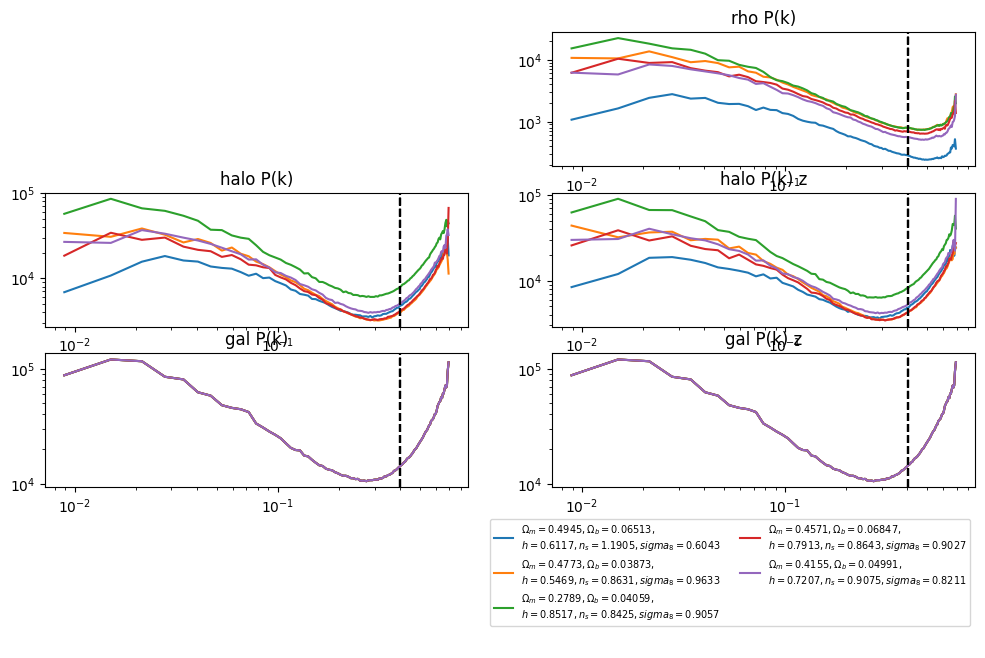

In [44]:
N = 256
L = 2000
k_nyq = np.pi * N / L
Nsamp = 5

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(4,2)

axs = [fig.add_subplot(gs[i]) for i in range(6)]

for i, ind in enumerate(np.random.choice(len(rho_pk), Nsamp, replace=False)):
    label = f"$\Omega_m={cosmos[ind,0]}, \Omega_b={cosmos[ind,1]}, $\n"
    label += f"$h={cosmos[ind,2]}, n_s={cosmos[ind,3]}, sigma_8={cosmos[ind,4]}$"

    # survey Pk
    ax = axs[0]
    ax.axis('off')
    # ax.loglog(k_sur, survey_pk[ind], label=label)
    # ax.axvline(k_nyq, ls='--', c='k')
    # ax.set_title('survey P(k)')

    # rho Pk
    ax = axs[1]
    ax.loglog(k, rho_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('rho P(k)')

    # halo Pk
    ax = axs[2]
    ax.loglog(k, halo_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('halo P(k)')

    # haloz Pk
    ax = axs[3]
    ax.loglog(k, haloz_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('halo P(k) z')

    # gal Pk
    ax = axs[4]
    ax.loglog(k, gal_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('gal P(k)')

    # galz Pk
    ax = axs[5]
    ax.loglog(k, galz_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('gal P(k) z')
    h, l = ax.get_legend_handles_labels()

ax = fig.add_subplot(gs[7:])
ax.axis('off')
ax.legend(h, l, fontsize=7, ncol=2);

### Inference

In [1]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cpu'

def run_inference(x, theta):
    loader = NumpyLoader(x=x, theta=theta)

    # define a prior
    prior = ili.utils.Uniform(
        low=theta.min(axis=0),
        high=theta.max(axis=0),
        device=device)

    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
        # ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
    ]

    # define training arguments
    train_args = {
        'training_batch_size': 32,
        'learning_rate': 1e-4
    }

    # initialize the trainer
    runner = InferenceRunner.load(
        backend='lampe',
        engine='NPE',
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args
    )

    # train the model
    posterior_ensemble, summaries = runner(loader=loader)

    return posterior_ensemble, summaries

In [33]:
test_frac = 0.1
np.random.seed(42)
in_test = np.random.rand(len(cosmos)) < test_frac

In [34]:
kmin = 0.4
def log_and_mask(x):
    x = x[:, k > kmin]
    x = np.log10(x)
    mask = np.any(np.isnan(x), axis=0)
    mask *= np.any(np.isinf(x), axis=0)
    x = x[:,~mask]
    return x

rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk = map(
    log_and_mask,
    [rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk]
)
# rho_pk = log_and_mask(rho_pk)
# survey_pk = log_and_mask(survey_pk)

In [35]:
def mask_inf(x):
    mask = np.any(np.isnan(x), axis=0)
    mask *= np.any(np.isinf(x), axis=0)
    return x[:,~mask]

rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk = map(
    mask_inf,
    [rho_pk, halo_pk, haloz_pk, gal_pk, galz_pk]
)
# rho_pk = mask_inf(rho_pk)
# survey_pk = mask_inf(survey_pk)

In [38]:
k[:95]

array([0.00444982, 0.00753956, 0.01072395, 0.0139183 , 0.0171755 ,
       0.02023943, 0.02338358, 0.02654113, 0.02972681, 0.03288112,
       0.03598316, 0.0391393 , 0.04235199, 0.04548427, 0.04860395,
       0.05173815, 0.05487882, 0.05802715, 0.06118348, 0.06434086,
       0.06747504, 0.07059748, 0.07375668, 0.07689325, 0.08003288,
       0.08319956, 0.08635978, 0.08948826, 0.09261768, 0.09574034,
       0.09889449, 0.10204689, 0.10519697, 0.10834549, 0.11148501,
       0.114631  , 0.11775708, 0.12089553, 0.12404283, 0.12717461,
       0.13031671, 0.13346287, 0.13662117, 0.13977648, 0.14291831,
       0.14604381, 0.14917249, 0.15231913, 0.15546396, 0.15860841,
       0.16175938, 0.16490841, 0.16805882, 0.17118502, 0.17432391,
       0.17747058, 0.18059585, 0.18373835, 0.18688239, 0.1900327 ,
       0.19317699, 0.19630701, 0.19946323, 0.20260366, 0.20574582,
       0.20889071, 0.21202003, 0.21517128, 0.21831793, 0.22144981,
       0.22458172, 0.22772071, 0.23088172, 0.23403221, 0.23717

In [39]:
print('rho')
prho, srho = run_inference(rho_pk, cosmos)

print('halo')
phalo, shalo = run_inference(halo_pk, cosmos)

print('haloz')
phaloz, shaloz = run_inference(haloz_pk, cosmos)

print('gal')
pgal, sgal = run_inference(gal_pk, cosmos)

print('galz')
pgalz, sgalz = run_inference(galz_pk, cosmos)

# print('survey')
# psurvey, ssurvey = run_inference(survey_pk, cosmos)

INFO:root:MODEL INFERENCE CLASS: NPE


rho


INFO:root:Training model 1 / 1.
381 epochs [02:10,  2.91 epochs/s, loss=-12.3, loss_val=-10.6]
INFO:root:It took 130.9853961467743 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


halo


326 epochs [01:51,  2.92 epochs/s, loss=-10.8, loss_val=-10.4]
INFO:root:It took 111.51915955543518 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


haloz


296 epochs [01:41,  2.91 epochs/s, loss=-10.8, loss_val=-10.2]
INFO:root:It took 101.66537809371948 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


gal


240 epochs [01:23,  2.89 epochs/s, loss=-10.6, loss_val=-9.93]
INFO:root:It took 83.19812774658203 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


galz


431 epochs [02:28,  2.89 epochs/s, loss=-13, loss_val=-11.6]  
INFO:root:It took 148.97137808799744 seconds to train models.


INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples: 1597it [00:00, 9525.58it/s]                         
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1706it [00:00, 9408.54it/s]                         


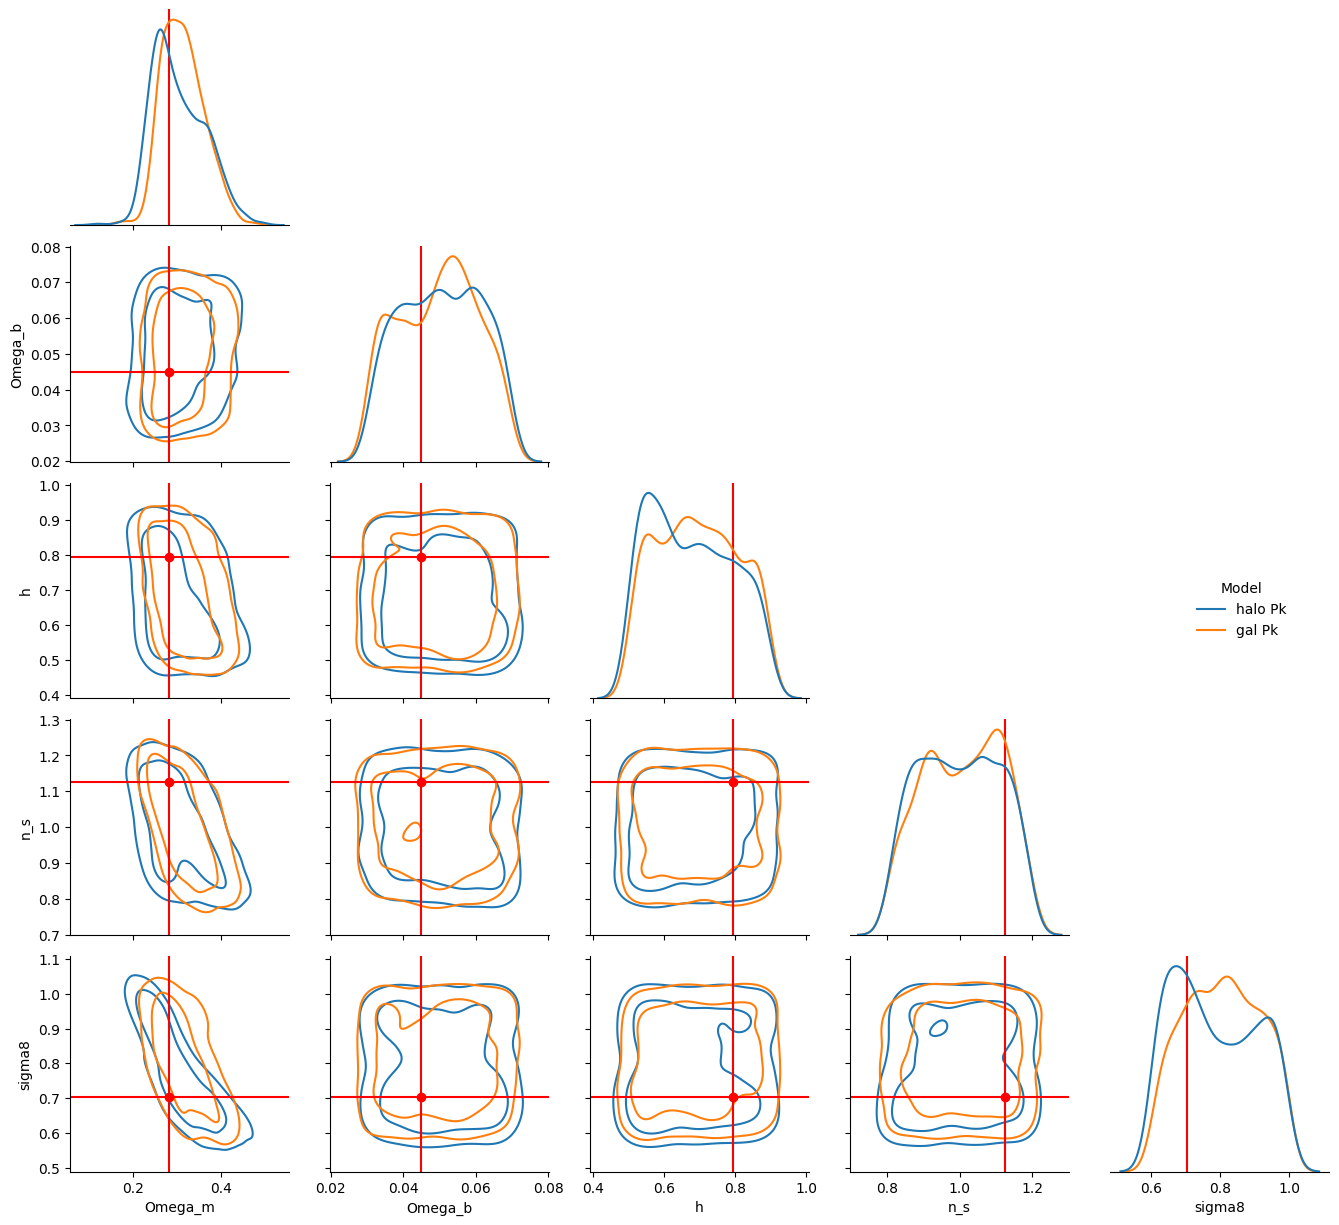

In [45]:
# ind = np.random.choice(np.argwhere(in_test).flatten())
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = None
# fig = metric(
#     posterior=prho,
#     x_obs=rho_pk[ind], theta_fid=cosmos[ind],
#     grid=fig,
#     name='rho Pk'
# )
fig = metric(
    posterior=phalo,
    x_obs=halo_pk[ind], theta_fid=cosmos[ind],
    grid=fig,
    name='halo Pk'
)
# fig = metric(
#     posterior=phaloz,
#     x_obs=haloz_pk[ind], theta_fid=cosmos[ind],
#     grid=fig,
#     name='halo Pk z'
# )
fig = metric(
    posterior=pgal,
    x_obs=gal_pk[ind], theta_fid=cosmos[ind],
    grid=fig,
    name='gal Pk'
)
# fig = metric(
#     posterior=pgalz,
#     x_obs=galz_pk[ind], theta_fid=cosmos[ind],
#     grid=fig,
#     name='gal Pk z'
# )

In [46]:
hpos = np.load('/automnt/data74/chartier/abacus/138/halo_pos.npy')
import MAS_library as MASL
import Pk_library as PKL

def MA(pos, L, N, MAS='CIC'):
    pos = np.ascontiguousarray(pos)
    delta = np.zeros((N, N, N), dtype=np.float32)
    MASL.MA(pos, delta, BoxSize=L, MAS=MAS)
    delta /= np.mean(delta, dtype=np.float64)
    delta -= 1
    return delta

def calcPk(delta, L, axis=0, MAS='CIC', threads=16):
    Pk = PKL.Pk(delta, L, axis, MAS, threads, verbose=False)
    k = Pk.k3D
    Pk = Pk.Pk
    return k, Pk

N = 256
L = 2000
MAS = 'CIC'
threads = 16
haba = MA(hpos, L, N, MAS)
k, Pka = calcPk(haba, L, MAS=MAS, threads=threads)

: 

: 

: 

INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples: 1065it [00:00, 7509.10it/s]             
INFO:root:Sampling models with tensor([1000.]) samples each.
Drawing 1000 posterior samples: 1534it [00:00, 4077.15it/s]                         


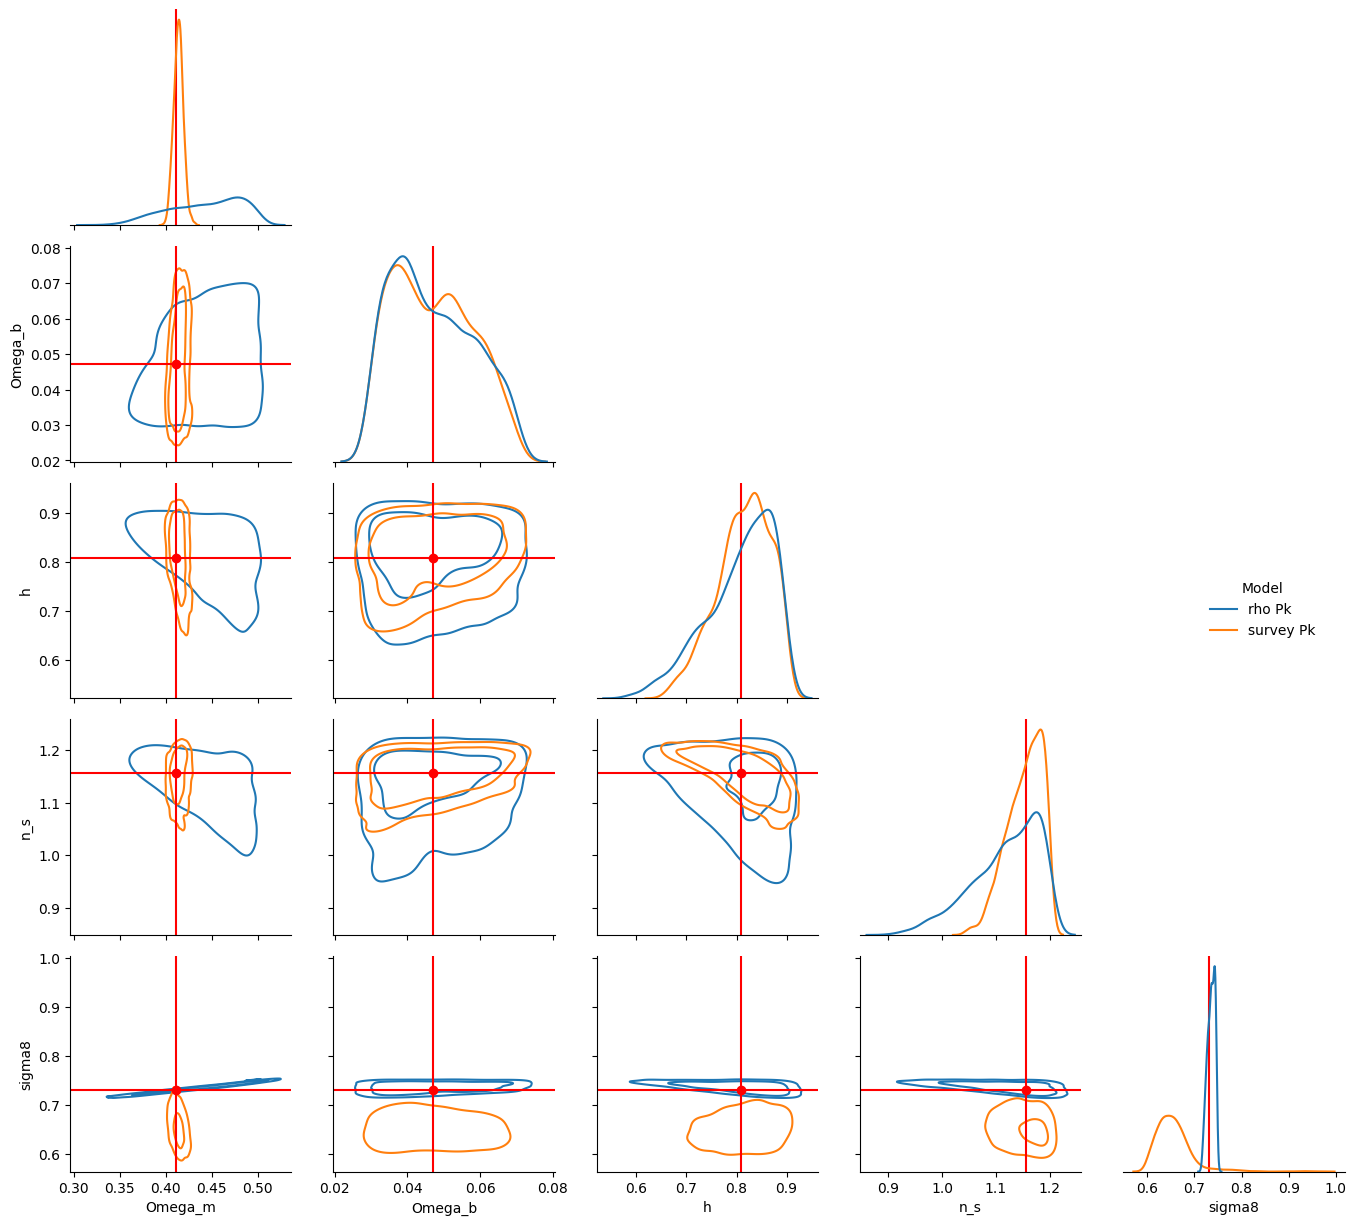

In [46]:
ind = np.random.choice(np.argwhere(in_test).flatten())
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct',
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)
fig = metric(
    posterior=prho,
    x_obs=rho_pk[ind][:-1], theta_fid=cosmos[ind],
    name='rho Pk'
)
fig = metric(
    posterior=psurvey,
    x_obs=survey_pk[ind], theta_fid=cosmos[ind],
    grid=fig,
    name='survey Pk'
)

### Quijote HOD+cosmo

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf
import h5py

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')


### MTNG cosmo

In [ ]:
diagpath = '/automnt/data80/mattho/cmass-ili/mtng/nbody/L3000-N384/0/diag'